In [1]:
# Install everything cleanly at the beginning of notebook
!pip install --quiet scipy==1.10.1 numpy==1.24.4 gensim nltk spacy==3.8.0 torch==2.0.1
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 69.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
# ─── ENV SETUP ────────────────────────────────────────────────────────────────
import os
import logging
import datetime
import requests
import time
import numpy as np
import pandas as pd
import re
from collections import Counter

# Silence TensorFlow-related warnings (we’re using PyTorch)
os.environ["TRANSFORMERS_NO_TF"] = "1"
os.environ["HF_HUB_DISABLE_SYMLINKS_WARNING"] = "1"

# ─── LIBRARIES ────────────────────────────────────────────────────────────────
import spacy
from transformers import pipeline

# ─── LOAD MODELS ──────────────────────────────────────────────────────────────
nlp = spacy.load("en_core_web_sm")
finbert_classifier = pipeline("sentiment-analysis",
                                model="yiyanghkust/finbert-tone",
                                tokenizer="yiyanghkust/finbert-tone")

# ─── FINNHUB API KEY ─────────────────────────────────────────────────────────────
# Replace with your Finnhub API key.
api_key = "cvm1bq9r01qnndmbg1pgcvm1bq9r01qnndmbg1q0"

# ─── HELPER FUNCTIONS ───────────────────────────────────────────────────────────
def get_news_finnhub(ticker, api_key, days_back=30):
    """
    Retrieves news articles for a given ticker from Finnhub.
    Adjust `days_back` as needed to collect more articles.
    """
    today = datetime.date.today()
    start_date = today - datetime.timedelta(days=days_back)
    url = f"https://finnhub.io/api/v1/company-news?symbol={ticker}&from={start_date}&to={today}&token={api_key}"
    res = requests.get(url)
    if res.status_code == 200:
        return res.json()
    else:
        print(f"[ERROR] Finnhub news API error for {ticker}: {res.status_code}")
        return []

def preprocess_text(text):
    """
    Cleans and normalizes the text using spaCy.
    """
    text = re.sub(r'<.*?>', ' ', text)
    text = re.sub(r'[^A-Za-z\s]', ' ', text)
    text = text.lower()
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    return " ".join(tokens)

def get_finbert_sentiment(text):
    """
    Uses FinBERT to label the text's sentiment.
    Truncates text to the first 512 characters (if necessary).
    """
    try:
        result = finbert_classifier(text[:512])[0]
        return result['label'].lower(), result['score']
    except Exception as e:
        print(f"[FINBERT ERROR] {e}")
        return "neutral", 0.0

# ─── MAIN PIPELINE ─────────────────────────────────────────────────────────────
def run_pipeline(tickers, api_key, days_back=30):
    """
    For each ticker, retrieves Finnhub news articles from the past `days_back` days,
    processes the text, labels it using FinBERT, and stores the results in a CSV.
    """
    records = []
    for ticker in tickers:
        print(f"🔎 Processing {ticker}")
        news_items = get_news_finnhub(ticker, api_key, days_back)
        for item in news_items:
            headline = item.get("headline", "")
            summary = item.get("summary", "")
            # If both headline and summary are missing, skip
            if not headline and not summary:
                continue

            full_text = f"{headline} {summary}"
            published_ts = item.get("datetime", None)
            if not published_ts:
                continue

            # Convert the Unix timestamp to a datetime object
            pub_dt = datetime.datetime.fromtimestamp(published_ts)

            # Optional: Skip future articles (should not happen, but for safety)
            if pub_dt.date() >= datetime.date.today():
                continue

            # Preprocess text
            clean_text = preprocess_text(full_text)
            # Label with FinBERT
            finbert_label, finbert_score = get_finbert_sentiment(clean_text)

            records.append({
                "ticker": ticker,
                "headline": headline,
                "summary": summary,
                "clean_text": clean_text,
                "news_time": pub_dt,
                "finbert_label": finbert_label,
                "finbert_score": finbert_score
            })
            time.sleep(0.4)  # To avoid rate limits

    df = pd.DataFrame(records)
    # Save dataset to CSV in the working directory
    output_path = os.path.abspath("finnhub_labeled_news_dataset.csv")
    df.to_csv(output_path, index=False)
    print(f"✅ Done. Dataset saved to {output_path}")
    return df

# ─── DEFINE TICKERS (Add more top companies as needed) ─────────────────────────
tickers = [
    "AAPL", "MSFT", "GOOG", "AMZN", "TSLA", "NVDA", "META", "NFLX", "INTC", "ADBE", "ORCL", "IBM"
]

# ─── RUN THE PIPELINE ──────────────────────────────────────────────────────────
df = run_pipeline(tickers, api_key, days_back=30)
df.head()


KeyboardInterrupt: 

In [ ]:
from google.colab import files
files.download("/content/finnhub_labeled_news_dataset.csv")

In [2]:
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# File paths
file_path_1 = '/content/drive/MyDrive/MLapps/finnhub_labeled_news_dataset.csv'
file_path_2 = '/content/drive/MyDrive/MLapps/finnhub_labeled_news_dataset0.csv'

# Load both datasets
try:
    df1 = pd.read_csv(file_path_1)
    df2 = pd.read_csv(file_path_2)
    print("Both datasets loaded successfully!")

    # Concatenate them (ignore index to avoid duplicate row indices)
    df = pd.concat([df1, df2], ignore_index=True)
    print(f"Combined dataset shape: {df.shape}")
    print(df.head())

except FileNotFoundError as e:
    print(f"File not found: {e.filename}")
except pd.errors.EmptyDataError as e:
    print(f"One of the files is empty: {e}")
except pd.errors.ParserError as e:
    print(f"Parser error: {e}")
except Exception as e:
    print(f"Unexpected error: {e}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Both datasets loaded successfully!
Combined dataset shape: (3003, 7)
  ticker                                           headline  \
0   AAPL  Apple fans spent $1,199 on an iPhone — Bitcoin...   
1   AAPL  Survey Shows Pent-Up Demand For New Apple iPhones   
2   AAPL  Sector Update: Tech Stocks Higher in Late Afte...   
3   AAPL  Apple Rebuilds Siri Team With Vision Pro Veter...   
4   AAPL  Bessent Calls U.S.-China Trade War Unsustainab...   

                                             summary  \
0  If you purchased Bitcoin instead of Apple's ic...   
1  A survey of U.S. consumers in March indicates ...   
2  Tech stocks were rising late Tuesday afternoon...   
3  Apple brings in new faces from Vision Pro team...   
4  The U.S.-China standoff over tariffs is unsust...   

                                          clean_text         news_time  \
0  apple fan

In [3]:
pip install --quiet xgboost joblib

In [4]:
import re, spacy, nltk, numpy as np
from tqdm.auto import tqdm
from nltk.corpus import stopwords
nltk.download("punkt"); nltk.download("stopwords")

# Remove rows with missing text
df = df.dropna(subset=["clean_text"]).reset_index(drop=True)

texts  = df["clean_text"].astype(str).tolist()
labels = df["finbert_label"].tolist()
label_map = {"negative":0, "neutral":1, "positive":2}
y       = np.array([label_map[l] for l in labels])

nlp = spacy.load("en_core_web_sm", disable=["parser","ner"])
stop_words = set(stopwords.words("english"))

def preprocess(txt):
    txt = re.sub(r"<.*?>", " ", txt)
    txt = re.sub(r"[^A-Za-z\s]", " ", txt).lower()
    doc = nlp(txt)
    return [t.lemma_ for t in doc if t.is_alpha and t.lemma_ not in stop_words]

tokenized = [preprocess(t) for t in tqdm(texts, desc="Tokenizing")]


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Tokenizing:   0%|          | 0/3003 [00:00<?, ?it/s]

In [5]:
from sklearn.model_selection import train_test_split
clean_strings = [" ".join(toks) for toks in tokenized]

X_train_txt, X_test_txt, y_train, y_test, tok_train, tok_test = train_test_split(
    clean_strings, y, tokenized, test_size=0.20, stratify=y, random_state=42
)


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib, scipy.sparse as sp, os

tfidf_vect = TfidfVectorizer(max_features=10_000,
                             ngram_range=(1,2),
                             norm="l2",
                             smooth_idf=True)
X_train_tfidf = tfidf_vect.fit_transform(X_train_txt)
X_test_tfidf  = tfidf_vect.transform(X_test_txt)

os.makedirs("features", exist_ok=True)
pd.DataFrame(X_train_tfidf.toarray()).to_parquet("features/X_train_tfidf.parquet")
pd.DataFrame(X_test_tfidf.toarray()).to_parquet("features/X_test_tfidf.parquet")
joblib.dump(tfidf_vect.get_feature_names_out(), "features/tfidf_vocab.pkl")


['features/tfidf_vocab.pkl']

In [7]:
import joblib

# Assuming tfidf_vect is already trained
vocab = tfidf_vect.get_feature_names_out()
joblib.dump(vocab, "features/tfidf_vocab.pkl")


['features/tfidf_vocab.pkl']

In [8]:
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
import zipfile, requests, numpy as np, os

# Download & convert once
glove_txt = "glove.6B.100d.txt"
if not os.path.exists(glove_txt):
    url = "http://nlp.stanford.edu/data/glove.6B.zip"
    with requests.get(url, stream=True) as r, open("glove.zip","wb") as f:
        for chunk in r.iter_content(1_000_000):
            f.write(chunk)
    with zipfile.ZipFile("glove.zip") as zf:
        zf.extract("glove.6B.100d.txt")
if not os.path.exists("glove.word2vec.txt"):
    glove2word2vec(glove_txt, "glove.word2vec.txt")
glove = KeyedVectors.load_word2vec_format("glove.word2vec.txt", binary=False)

def doc_emb(tokens, model, dim=100):
    vecs = [model[w] for w in tokens if w in model]
    return np.mean(vecs, axis=0) if vecs else np.zeros(dim)

X_train_glove = np.vstack([doc_emb(t, glove) for t in tok_train])
X_test_glove  = np.vstack([doc_emb(t, glove) for t in tok_test])

np.save("features/X_train_glove.npy", X_train_glove)
np.save("features/X_test_glove.npy",  X_test_glove)


<ipython-input-8-6eb2db1a056d>:15: DeprecationWarning: Call to deprecated `glove2word2vec` (KeyedVectors.load_word2vec_format(.., binary=False, no_header=True) loads GLoVE text vectors.).
  glove2word2vec(glove_txt, "glove.word2vec.txt")


In [9]:
from gensim.models import Word2Vec
import numpy as np

# Train Word2Vec only on training data to prevent leakage
w2v_model = Word2Vec(
    sentences=tok_train,
    vector_size=100,
    window=5,
    min_count=2,
    workers=4,
    epochs=20
)

def doc_emb_w2v(tokens, model, dim=100):
    vecs = [model.wv[w] for w in tokens if w in model.wv]
    return np.mean(vecs, axis=0) if vecs else np.zeros(dim)

X_train_w2v = np.vstack([doc_emb_w2v(toks, w2v_model) for toks in tok_train])
X_test_w2v  = np.vstack([doc_emb_w2v(toks, w2v_model) for toks in tok_test])

np.save("features/X_train_w2v.npy", X_train_w2v)
np.save("features/X_test_w2v.npy",  X_test_w2v)

print("✅ Word2Vec matrix:", X_train_w2v.shape, "train /", X_test_w2v.shape, "test")

✅ Word2Vec matrix: (2402, 100) train / (601, 100) test


In [10]:
from collections import Counter
import numpy as np

# ─── 5. Lexicon-Based Representation ───────────────────────────────────────────
lm_positive = {
    "achieve", "advancement", "advantage", "appreciation", "benefit", "boom", "boost", "bullish",
    "climb", "competitive", "efficiency", "exceed", "expand", "favorable", "gain", "growth", "improve",
    "increase", "innovation", "leadership", "margin", "optimism", "opportunity", "outperform", "positive",
    "profit", "progress", "rebound", "record", "recovery", "reduction", "resilient", "return", "reward",
    "rise", "satisfy", "stability", "strong", "surpass", "up", "upgrade", "value", "win", "beat", "expand"
}

lm_negative = {
    "adverse", "bankrupt", "collapse", "crisis", "cut", "debt", "decline", "default", "deficit",
    "deteriorate", "disappoint", "drop", "down", "downgrade", "fall", "fail", "fear", "fraud", "impair",
    "inflation", "insolvency", "layoff", "liability", "litigation", "loss", "miss", "negative", "penalty",
    "plunge", "poor", "recession", "restructure", "risk", "scandal", "shrink", "shortfall", "slowdown",
    "strike", "uncertain", "underperform", "unemployment", "unfavorable", "weak", "writeoff"
}

lm_uncert = {
    "almost", "appear", "approximately", "assume", "believe", "could", "depend", "doubt", "estimate",
    "expect", "fluctuate", "guess", "hope", "indicate", "likely", "may", "maybe", "might", "perhaps",
    "possible", "possibility", "potential", "presume", "probably", "project", "risk", "seem", "should",
    "suggest", "suppose", "trend", "uncertain", "uncertainty", "volatile", "volatility", "forecast",
    "projection", "speculate"
}

def lexicon_feats(tokens):
    counts = Counter(tokens)
    total = max(len(tokens), 1)
    return np.array([
        sum(counts[w] for w in lm_positive) / total,
        sum(counts[w] for w in lm_negative) / total,
        sum(counts[w] for w in lm_uncert)  / total
    ])

X_train_lex = np.vstack([lexicon_feats(toks) for toks in tok_train])
X_test_lex  = np.vstack([lexicon_feats(toks) for toks in tok_test])

np.save("features/X_train_lex.npy", X_train_lex)
np.save("features/X_test_lex.npy",  X_test_lex)

print("✅ Lexicon matrix:", X_train_lex.shape, "train /", X_test_lex.shape, "test")

✅ Lexicon matrix: (2402, 3) train / (601, 3) test


In [11]:
# ─── 6. Save Feature Matrices for Task 2 ──────────────────────────────────────
os.makedirs("features", exist_ok=True)

# Save TF-IDF (train only, already dense)
pd.DataFrame(X_train_tfidf.toarray()).to_parquet("features/X_tfidf.parquet")

# Save dense arrays (train only)
np.save("features/X_glove.npy", X_train_glove)
np.save("features/X_w2v.npy",   X_train_w2v)
np.save("features/X_lex.npy",   X_train_lex)

# Save labels (train only)
labels_series = pd.Series(y_train, name="finbert_label")
labels_series.to_csv("features/labels.csv", index=False)

print("✅ All feature sets saved in ./features/")

✅ All feature sets saved in ./features/


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
import joblib, os

os.makedirs("models", exist_ok=True)

# ----- TF‑IDF Logistic
log_tfidf = LogisticRegression(max_iter=400, class_weight="balanced", n_jobs=-1)
log_tfidf.fit(X_train_tfidf, y_train)
joblib.dump(log_tfidf, "models/LogReg_TFIDF.pkl")

# ----- LinearSVC + calibration
svc        = LinearSVC(C=1.0, class_weight="balanced")
svc.fit(X_train_tfidf, y_train)
svc_prob   = CalibratedClassifierCV(svc, method="sigmoid", cv=3)
svc_prob.fit(X_train_tfidf, y_train)
joblib.dump(svc_prob, "models/LinSVC_TFIDF_CAL.pkl")

# ----- XGB on GloVe
xgb = XGBClassifier(objective="multi:softprob",
                    num_class=3,
                    eval_metric="mlogloss",
                    n_estimators=250,
                    max_depth=5,
                    learning_rate=0.1,
                    subsample=0.9,
                    colsample_bytree=0.9,
                    tree_method="hist",
                    n_jobs=-1,
                    random_state=42)
xgb.fit(X_train_glove, y_train)
joblib.dump(xgb, "models/XGB_GLOVE.pkl")

# ----- Quick sanity F1
print("LogReg F1:", f1_score(y_test, log_tfidf.predict(X_test_tfidf), average="macro"))
print("SVC    F1:", f1_score(y_test, svc_prob.predict(X_test_tfidf), average="macro"))
print("XGB    F1:", f1_score(y_test, xgb.predict(X_test_glove),  average="macro"))


LogReg F1: 0.7362454343670383
SVC    F1: 0.7420315816117915
XGB    F1: 0.6984319227626544


In [13]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import f1_score

# Recombine features
X_train_comb = np.hstack([X_train_tfidf.toarray(), X_train_glove])
X_test_comb  = np.hstack([X_test_tfidf.toarray(),  X_test_glove])

# Ensemble with LogReg, SVC, and XGB
ensemble = VotingClassifier(
    estimators=[
        ("logreg", log_tfidf),
        ("svc", svc_prob),
        ("xgb", xgb)
    ],
    voting="soft",
    weights=[2, 3, 1]  # Boost SVC
)

ensemble.fit(X_train_comb, y_train)
y_pred_ens = ensemble.predict(X_test_comb)

f1 = f1_score(y_test, y_pred_ens, average="macro")
print("🔁 Improved Ensemble macro‑F1:", round(f1, 4))
joblib.dump(ensemble, "models/ensemble_full_weighted.pkl")

🔁 Improved Ensemble macro‑F1: 0.7684


['models/ensemble_full_weighted.pkl']

In [14]:
# prompt: how to install the shap library without dependencie issues with my actual libraries i use

!pip install shap


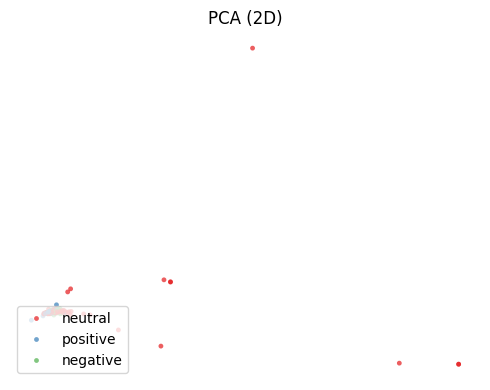

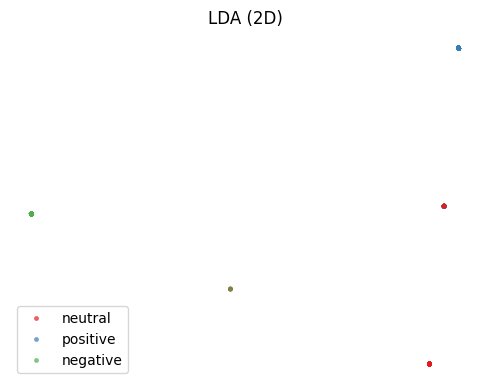

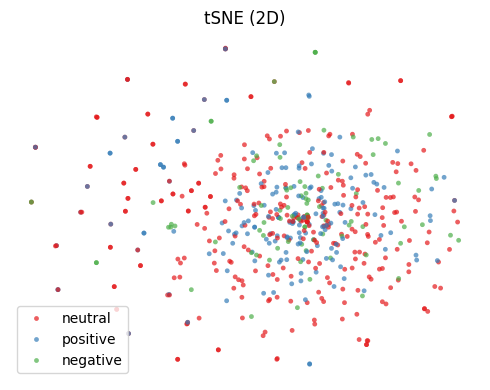

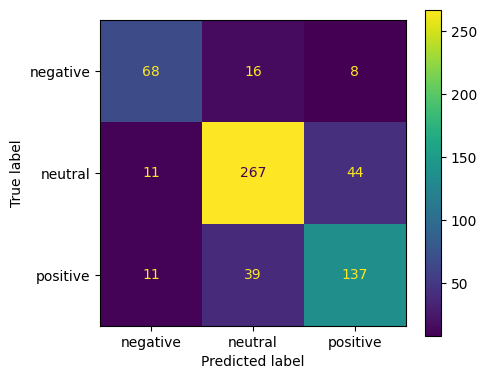

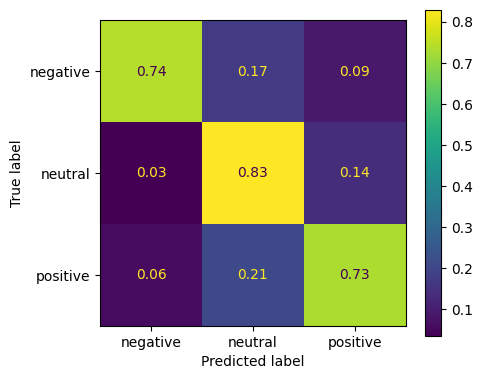

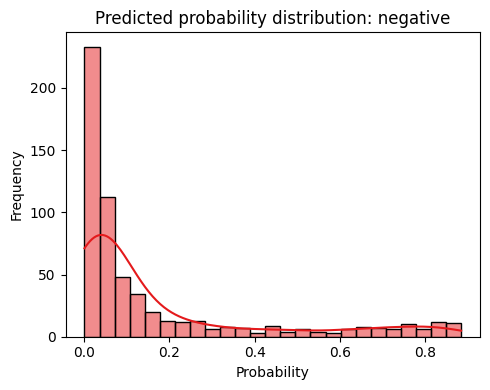

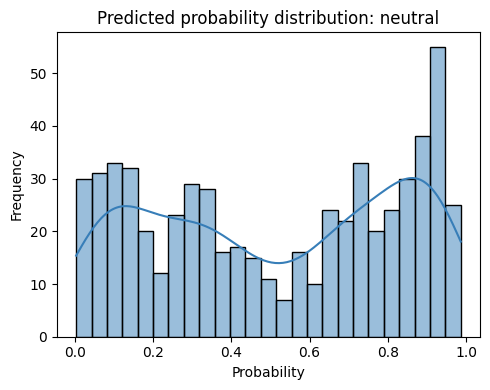

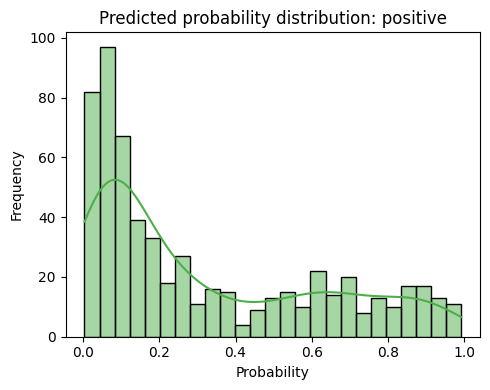

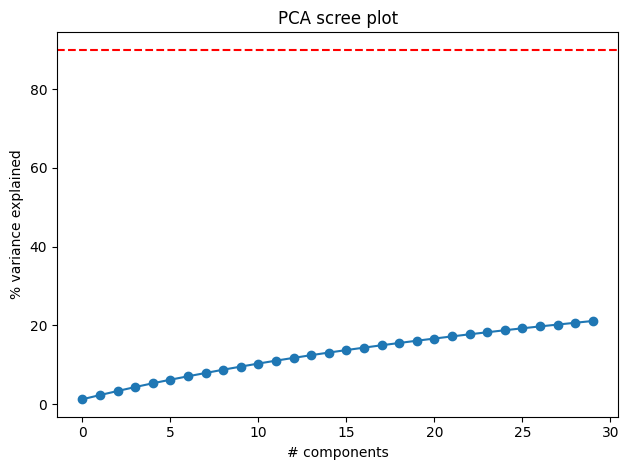

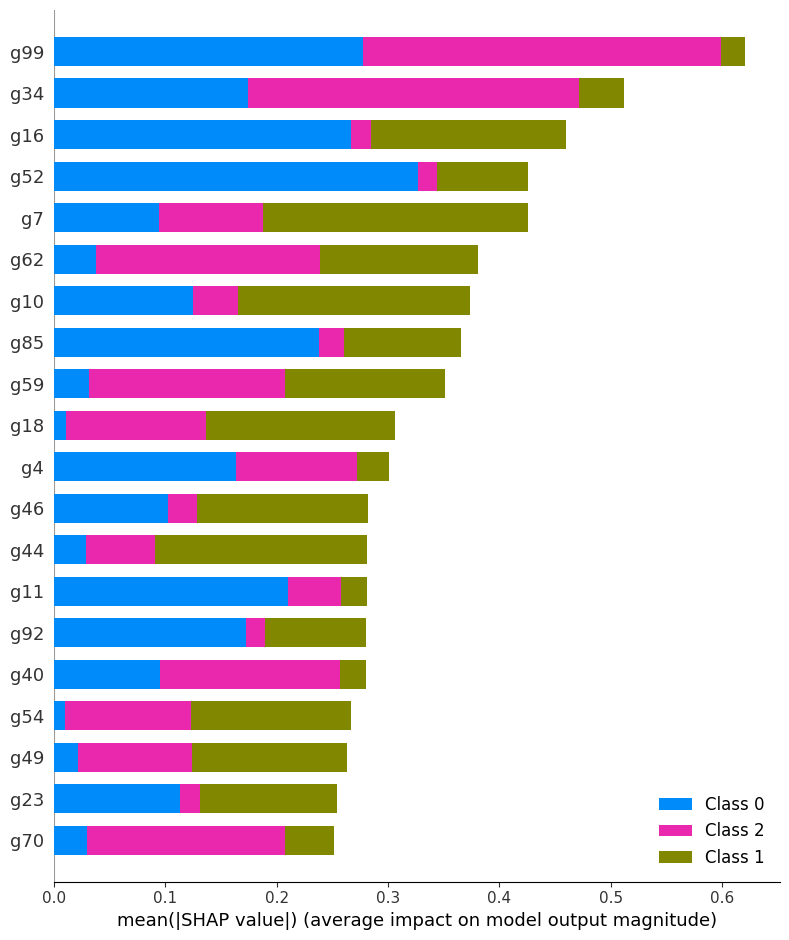

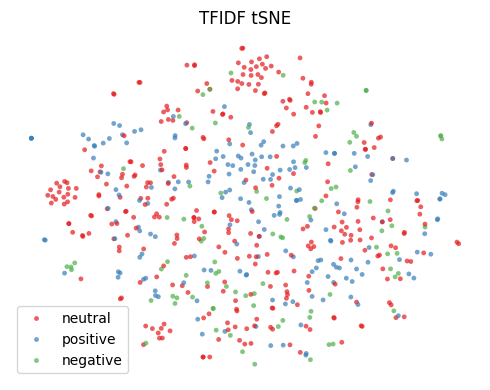

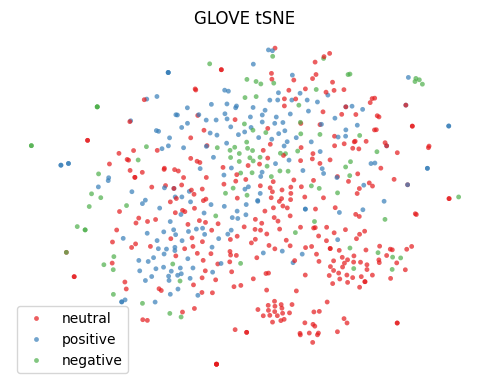

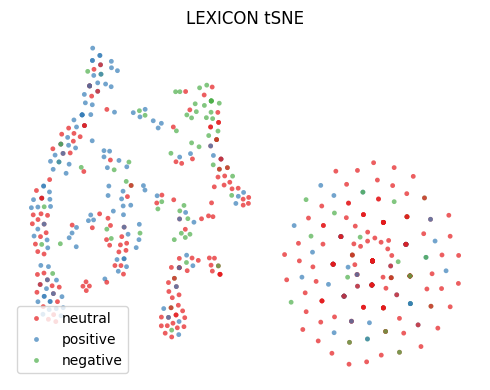

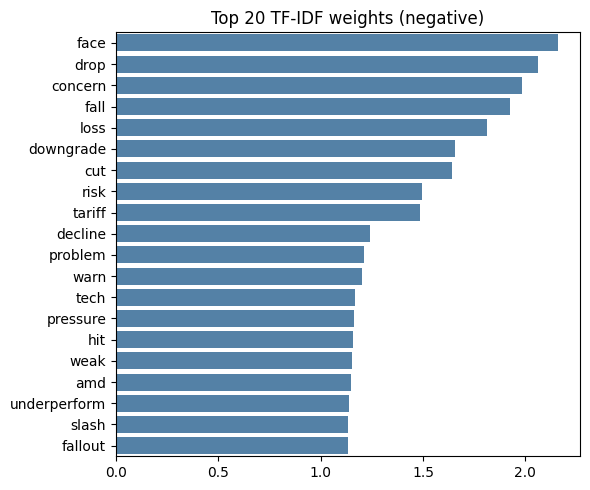

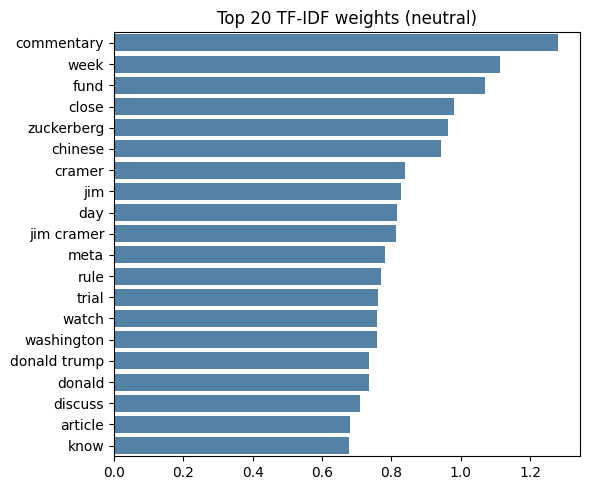

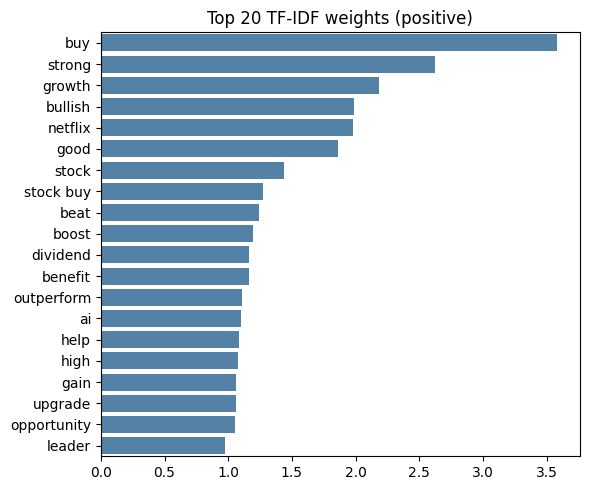

In [ ]:
# ─────────────────────────────────────────────────────────────────────────────
#  UNIVERSAL PLOT BLOCK  –  works with your current variables
# ─────────────────────────────────────────────────────────────────────────────
import os, numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns, joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
import shap

# ---------------------------------------------------------------------------
# 1)  Get the *correct* y_test (no NaNs, 1‑to‑1 with X_test_* matrices)
#     We re‑split labels with SAME parameters → deterministic 601 test rows.
# ---------------------------------------------------------------------------
label_map = {"negative":0, "neutral":1, "positive":2}
y_full = np.array([label_map.get(l, np.nan) for l in df["finbert_label"]])
_, y_test_plot = train_test_split(y_full, test_size=0.20,
                                  stratify=y_full, random_state=42)
# Remove any rows whose label was unmapped / NaN
valid = ~np.isnan(y_test_plot)
y_test_clean = y_test_plot[valid].astype(int)

# ---------------------------------------------------------------------------
# 2)  Build corresponding X_test matrices (601 rows) and combine
# ---------------------------------------------------------------------------
X_test_tfidf_clean = X_test_tfidf[valid]
X_test_glove_clean = X_test_glove[valid]
X_test_lex_clean   = X_test_lex[valid]

'''X_all_plot = np.hstack([X_test_tfidf_clean, X_test_glove_clean, X_test_lex_clean])
X_scaled   = StandardScaler().fit_transform(X_all_plot)

label_names = ["negative","neutral","positive"]
pal         = sns.color_palette("Set1", 3)'''

# ---------------------------------------------------------------------------
# 3)  Helper for scatter plots
# ---------------------------------------------------------------------------
def scatter_2d(coords, title):
    plt.figure(figsize=(5,4))
    sns.scatterplot(x=coords[:,0], y=coords[:,1],
                    hue=[label_names[i] for i in y_test_clean],
                    palette=pal, s=12, alpha=0.7, linewidth=0)
    plt.title(title); plt.axis("off"); plt.legend(loc="lower left")
    plt.tight_layout()
    os.makedirs("plots", exist_ok=True)
    plt.savefig(f"plots/{title.replace(' ','_').lower()}.png", dpi=200)
    plt.show()

# ---------------------------------------------------------------------------
# 4)  Dim‑reduction plots (PCA, LDA, t‑SNE)
# ---------------------------------------------------------------------------
# Convert TF-IDF to dense if needed and re-concatenate
X_all_plot = np.hstack([
    X_test_tfidf_clean.toarray() if hasattr(X_test_tfidf_clean, "toarray") else X_test_tfidf_clean,
    X_test_glove_clean,
    X_test_lex_clean
])
X_scaled = StandardScaler().fit_transform(X_all_plot)

label_names = ["negative", "neutral", "positive"]
pal         = sns.color_palette("Set1", 3)

def scatter_2d(coords, title):
    plt.figure(figsize=(5,4))
    sns.scatterplot(x=coords[:,0], y=coords[:,1],
                    hue=[label_names[int(i)] for i in y_test_clean],
                    palette=pal, s=12, alpha=0.7, linewidth=0)
    plt.title(title); plt.axis("off"); plt.legend(loc="lower left")
    plt.tight_layout()
    os.makedirs("plots", exist_ok=True)
    plt.savefig(f"plots/{title.replace(' ','_').lower()}.png", dpi=200)
    plt.show()

# Run all 3 cleanly
scatter_2d(PCA(n_components=2).fit_transform(X_scaled), "PCA (2D)")
scatter_2d(LDA(n_components=2).fit_transform(X_scaled, y_test_clean), "LDA (2D)")
scatter_2d(TSNE(n_components=2, perplexity=30, random_state=42, init="pca").fit_transform(X_scaled), "tSNE (2D)")

# ---------------------------------------------------------------------------
# 5)  Confusion matrix   (ensemble vs clean y_test)
# ---------------------------------------------------------------------------
os.makedirs("/content/drive/MyDrive/MLapps/plots", exist_ok=True)
y_pred_test = ensemble.predict(np.hstack([X_test_tfidf_clean, X_test_glove_clean]))

for norm, name in [(None,"confusion_counts"),("true","confusion_normalized")]:
    fig, ax = plt.subplots(figsize=(5,4))
    ConfusionMatrixDisplay.from_predictions(
        y_test_clean, y_pred_test, display_labels=label_names,
        cmap="viridis", colorbar=True, ax=ax, normalize=norm,
        values_format="d" if norm is None else ".2f")
    fig.tight_layout()
    fig.savefig(f"/content/drive/MyDrive/MLapps/plots/{name}.png", dpi=200)
plt.show()

# ---------------------------------------------------------------------------
# 6)  Probability distributions
# ---------------------------------------------------------------------------
probs = ensemble.predict_proba(np.hstack([X_test_tfidf_clean, X_test_glove_clean]))
for i, lab in enumerate(label_names):
    plt.figure(figsize=(5,4))
    sns.histplot(probs[:, i], kde=True, bins=25, color=pal[i])
    plt.title(f"Predicted probability distribution: {lab}")
    plt.xlabel("Probability"); plt.ylabel("Frequency"); plt.tight_layout()
    plt.savefig(f"/content/drive/MyDrive/MLapps/plots/prob_dist_{lab}.png", dpi=200)
    plt.show()

# ---------------------------------------------------------------------------
# 7)  Scree plot
# ---------------------------------------------------------------------------
pca_full = PCA(30).fit(X_scaled)
plt.plot(np.cumsum(pca_full.explained_variance_ratio_)*100, marker="o")
plt.axhline(90, color="red", linestyle="--")
plt.ylabel("% variance explained"); plt.xlabel("# components")
plt.title("PCA scree plot"); plt.tight_layout()
plt.savefig("plots/pca_scree.png", dpi=200); plt.show()

# ---------------------------------------------------------------------------
# 9)  SHAP summary (sample ≤400)
# ---------------------------------------------------------------------------
sample_idx = np.random.RandomState(42).choice(len(X_test_glove_clean),
                                              min(400,len(X_test_glove_clean)),
                                              replace=False)
explainer  = shap.TreeExplainer(xgb)
shap_vals  = explainer.shap_values(X_test_glove_clean[sample_idx])
plt.figure(figsize=(6,4))
shap.summary_plot(shap_vals, X_test_glove_clean[sample_idx],
                  feature_names=[f"g{i}" for i in range(X_test_glove_clean.shape[1])],
                  plot_type="bar", show=False)
plt.tight_layout(); plt.savefig("plots/xgb_shap.png", dpi=200); plt.show()

# ---------------------------------------------------------------------------
# 10)  t‑SNE per block
# ---------------------------------------------------------------------------
for name, mat in [("TFIDF",   X_test_tfidf_clean),
                  ("GLOVE",   X_test_glove_clean),
                  ("LEXICON", X_test_lex_clean)]:
    mat_arr = mat if isinstance(mat, np.ndarray) else mat.toarray()
    scatter_2d(TSNE(2, perplexity=30, random_state=42).fit_transform(mat_arr),
               f"{name} tSNE")

# ---------------------------------------------------------------------------
# 11)  TF‑IDF top words
# ---------------------------------------------------------------------------
vocab = joblib.load("features/tfidf_vocab.pkl")
coef  = log_tfidf.coef_
topk  = 20
for cls, lab in enumerate(label_names):
    idx = np.argsort(coef[cls])[-topk:][::-1]
    words, weights = [vocab[i] for i in idx], coef[cls][idx]
    plt.figure(figsize=(6,5))
    sns.barplot(x=weights, y=words, color="steelblue")
    plt.title(f"Top {topk} TF‑IDF weights ({lab})")
    plt.tight_layout()
    plt.savefig(f"plots/tfidf_top_{lab}.png", dpi=200); plt.show()

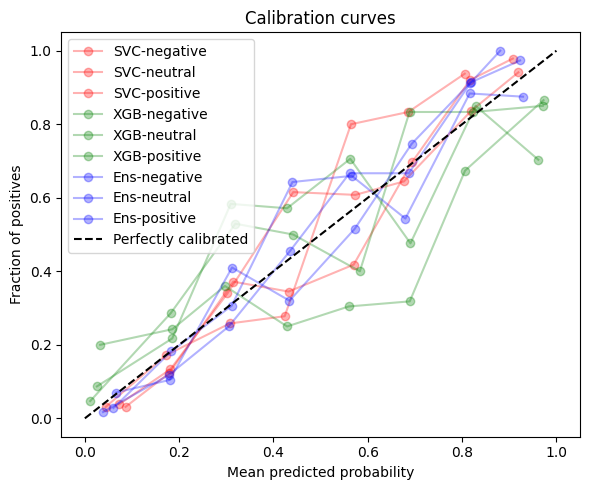

In [ ]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import os

# Make sure the plots directory exists
os.makedirs("plots", exist_ok=True)

fig, ax = plt.subplots(figsize=(6,5))
for (name, probs, color) in [("SVC", svc_prob, "red"), ("XGB", xgb_prob, "green"), ("Ens", ens_prob, "blue")]:
    for i, label in enumerate(label_names):
        y_true_bin = (y_test_clean == i).astype(int)
        prob_pred = probs[:, i]
        frac_pos, mean_pred = calibration_curve(y_true_bin, prob_pred, n_bins=8, strategy="uniform")

        ax.plot(mean_pred, frac_pos, marker='o', label=f"{name}-{label}", color=color, alpha=0.3)

# Perfect calibration reference
ax.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
ax.set_title("Calibration curves")
ax.set_xlabel("Mean predicted probability")
ax.set_ylabel("Fraction of positives")
ax.legend(loc="best")
fig.tight_layout()
fig.savefig("plots/calibration_curves.png", dpi=200)
plt.show()


In [16]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

# Train LDA on your dataset headlines
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
X_counts = vectorizer.fit_transform(df['clean_text'])

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X_counts)


LatentDirichletAllocation(n_components=5, random_state=42)

<ipython-input-65-20f5a77ff710>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_weights, y=top_words, ax=axes[topic_idx], palette="viridis")
<ipython-input-65-20f5a77ff710>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_weights, y=top_words, ax=axes[topic_idx], palette="viridis")
<ipython-input-65-20f5a77ff710>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_weights, y=top_words, ax=axes[topic_idx], palette="viridis")
<ipython-input-65-20f5a77ff710>:18: FutureWarning: 

Passing `palette` without assigning `hue` is de

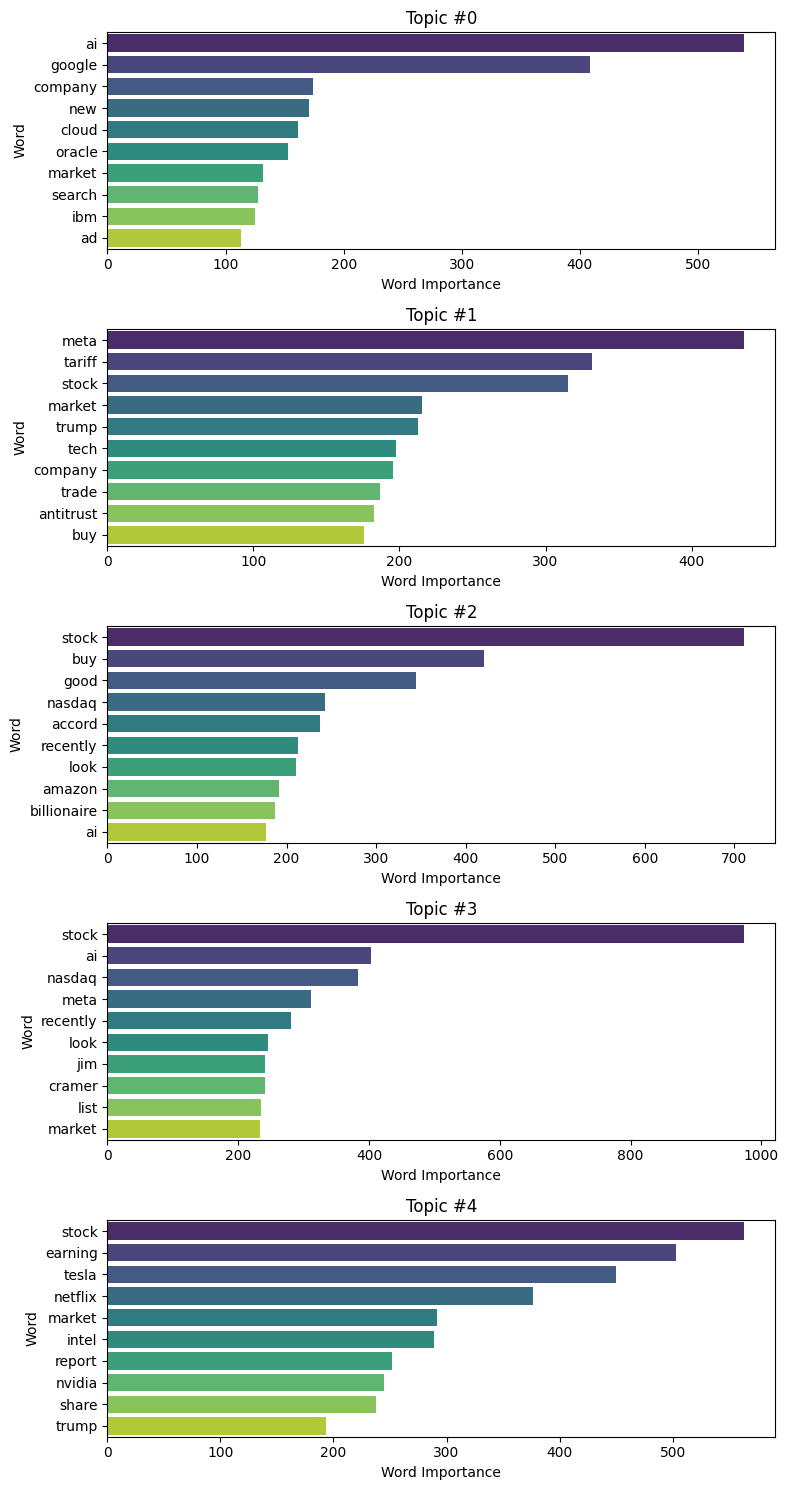

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Get the vocabulary
words = np.array(vectorizer.get_feature_names_out())

# Plotting
def plot_lda_topics(model, num_top_words=10):
    num_topics = model.components_.shape[0]
    fig, axes = plt.subplots(num_topics, 1, figsize=(8, num_topics * 3))

    for topic_idx, topic in enumerate(model.components_):
        top_word_indices = topic.argsort()[-num_top_words:][::-1]
        top_words = words[top_word_indices]
        top_weights = topic[top_word_indices]

        sns.barplot(x=top_weights, y=top_words, ax=axes[topic_idx], palette="viridis")
        axes[topic_idx].set_title(f"Topic #{topic_idx}")
        axes[topic_idx].set_xlabel("Word Importance")
        axes[topic_idx].set_ylabel("Word")

    plt.tight_layout()
    plt.show()

# Call the function
plot_lda_topics(lda, num_top_words=10)


In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

vocab = joblib.load("features/tfidf_vocab.pkl")  # your saved vocab
tfidf_vect = TfidfVectorizer(vocabulary=vocab)
tfidf_vect.fit(df["clean_text"])  # only needed if you want idf weighting again


TfidfVectorizer(vocabulary=array(['aapl', 'aapl close', 'aapl good', ..., 'zuckerberg take',
       'zuckerberg testify', 'zuckerberg witness'], dtype=object))

In [17]:
# ── Cell ② ────────────────────────────────────────────────────────────────
import numpy as np, pandas as pd, joblib, plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from tqdm.auto import tqdm

# -----------------------------------------------------------
# 0)  Load anything that is not already in RAM  ──────────────
# -----------------------------------------------------------
ensemble = joblib.load("models/ensemble_full_weighted.pkl")          # <─ your model
#  (If you previously joblib‑dumped lda / vectorizer you can
#   reload them too; otherwise they are already in memory.)

# -----------------------------------------------------------
# 1)  Build features for *all* rows – TF‑IDF + GloVe only
#     (That’s what the ensemble expects)
# -----------------------------------------------------------
print("➡️  Building TF‑IDF matrix …")
X_tfidf_full = tfidf_vect.transform(df["clean_text"])

print("➡️  Building GloVe matrix …")
X_glove_full = np.vstack([doc_emb(toks, glove) for toks in tqdm(tokenized)])

X_comb_full = np.hstack([X_tfidf_full.toarray(), X_glove_full])

# -----------------------------------------------------------
# 2)  Model outputs
# -----------------------------------------------------------
print("➡️  Running ensemble predictions …")
probs_full   = ensemble.predict_proba(X_comb_full)
pred_full    = probs_full.argmax(1)
df["pred_sentiment"]   = pred_full
df["prob_negative"]    = probs_full[:,0]
df["prob_neutral"]     = probs_full[:,1]
df["prob_positive"]    = probs_full[:,2]

label_names = {0:"negative",1:"neutral",2:"positive"}
df["pred_sentiment_str"] = df["pred_sentiment"].map(label_names)

# -----------------------------------------------------------
# 3)  2‑D document coordinates for the scatter
# -----------------------------------------------------------
print("➡️  Computing PCA(2) for scatter plot …")
coords = PCA(n_components=2, random_state=42)\
        .fit_transform(StandardScaler().fit_transform(X_comb_full))
df["x"], df["y"] = coords[:,0], coords[:,1]

# -----------------------------------------------------------
# 4)  Dominant LDA topic per document  +  top‑word dict
# -----------------------------------------------------------
print("➡️  Deriving dominant LDA topic …")
doc_topic = lda.transform(vectorizer.transform(df["clean_text"]))
df["topic"] = doc_topic.argmax(1)

print("➡️  Pre‑computing top words per topic …")
top_words_per_topic = {}
vocab = np.array(vectorizer.get_feature_names_out())
for k, comp in enumerate(lda.components_):
    idx = comp.argsort()[-10:][::-1]
    top_words_per_topic[k] = list(vocab[idx])

print("✅  Pre‑compute step done.")


➡️  Building TF‑IDF matrix …
➡️  Building GloVe matrix …


  0%|          | 0/3003 [00:00<?, ?it/s]

➡️  Running ensemble predictions …
➡️  Computing PCA(2) for scatter plot …
➡️  Deriving dominant LDA topic …
➡️  Pre‑computing top words per topic …
✅  Pre‑compute step done.


In [18]:
!pip install --quiet "dash==2.12.1" "jupyter-dash==0.4.2" dash-bootstrap-components plotly shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 38.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 229.3/229.3 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.8/101.8 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.6/233.6 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 39.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.4 which is incompatible.


In [19]:
# ─────────────────────────────────────────────────────────────────────────
# WORKING DASHBOARD + titles + Confusion‑matrix + Calibration‑curve
# ─────────────────────────────────────────────────────────────────────────
from jupyter_dash import JupyterDash
from dash import dcc, html, Input, Output, dash_table, callback
import dash_bootstrap_components as dbc
import plotly.express as px, plotly.graph_objects as go
from sklearn.metrics import confusion_matrix
from sklearn.calibration import calibration_curve
import pandas as pd

# Ensure numeric labels once
if "finbert_label_num" not in df.columns:
    df["finbert_label_num"] = df["finbert_label"].map({"negative":0,"neutral":1,"positive":2})

sentiment_opts = [{"label":l.title(), "value":i} for i,l in label_names.items()]
topic_opts     = [{"label":f"Topic {k}", "value":k} for k in sorted(df["topic"].unique())]

app = JupyterDash(__name__, external_stylesheets=[dbc.themes.FLATLY])

# ── layout ──────────────────────────────────────────────────────────────
app.layout = dbc.Container([
    html.H1("Fin‑News Sentiment Explorer", className="text-center my-2"),

    dbc.Row([
        dbc.Col(dcc.Dropdown(id="sentiment-filter", options=sentiment_opts,
                             value=[0,1,2], multi=True), md=6),
        dbc.Col(dcc.Dropdown(id="topic-filter", options=topic_opts,
                             value=[], multi=True), md=6)
    ]),

    dbc.Row([
        dbc.Col(dcc.Graph(id="scatter-docs"), md=7),
        dbc.Col(dcc.Graph(id="topic-bar"),   md=5),
    ]),

    dbc.Row([
        dbc.Col(dcc.Graph(id="prob-hist"), md=6),
        dbc.Col(dcc.Graph(id="conf-mat"),  md=6),
    ]),

    dbc.Row([
        dbc.Col(dcc.Graph(id="calib-curve"), md=6),
        # uncomment next two lines if you also want ROC‑AUC
        # dbc.Col(dcc.Graph(id="roc-auc"),   md=6),
    ]),

    dash_table.DataTable(
        id="news-table", page_size=10,
        columns=[{"name":c, "id":c} for c in ["headline","pred_sentiment_str","topic"]],
        style_cell={"whiteSpace":"normal","textAlign":"left"},
        style_table={"overflowX":"auto"})
], fluid=True)

# ── helper ───────────────────────────────────────────────────────────────
def _view(sentiments, topics, selected):
    mask = df["pred_sentiment"].isin(sentiments)
    if topics: mask &= df["topic"].isin(topics)
    if selected and selected.get("points"):
        mask &= df.index.isin([p["pointIndex"] for p in selected["points"]])
    return df[mask]

# ── callbacks ────────────────────────────────────────────────────────────
@callback(Output("scatter-docs","figure"),
          Input("sentiment-filter","value"),
          Input("topic-filter","value"))
def scatter_cb(sents, topics):
    dff = _view(sents, topics, None)
    fig = px.scatter(dff, x="x", y="y", color="pred_sentiment_str",
                     hover_data=["headline","topic"],
                     category_orders={"pred_sentiment_str":["negative","neutral","positive"]},
                     labels={"x":"PC‑1","y":"PC‑2"})
    fig.update_layout(title="PCA scatter")
    return fig

@callback(Output("topic-bar","figure"), Input("topic-filter","value"))
def bar_cb(topics):
    k = topics[0] if topics else 0
    words   = top_words_per_topic[k]
    weights = lda.components_[k][np.argsort(lda.components_[k])[-10:]][::-1]
    fig = px.bar(x=weights, y=words, orientation="h", labels={"x":"Weight","y":"Word"})
    fig.update_layout(title=f"Top words – Topic {k}", yaxis=dict(autorange="reversed"))
    return fig

@callback(Output("prob-hist","figure"),
          Input("sentiment-filter","value"),
          Input("topic-filter","value"),
          Input("scatter-docs","selectedData"))
def hist_cb(sents, topics, sel):
    dff = _view(sents, topics, sel)
    fig = go.Figure()
    for lab in ["negative","neutral","positive"]:
        fig.add_trace(go.Histogram(x=dff[f"prob_{lab}"], name=lab.title(), opacity=0.6))
    fig.update_layout(barmode="overlay", title="Predicted‑probability histogram",
                      xaxis_title="Probability", yaxis_title="Count")
    return fig

@callback(Output("conf-mat","figure"),
          Input("sentiment-filter","value"),
          Input("topic-filter","value"),
          Input("scatter-docs","selectedData"))
def conf_cb(sents, topics, sel):
    dff = _view(sents, topics, sel)
    cm = confusion_matrix(dff["finbert_label_num"], dff["pred_sentiment"], labels=[0,1,2])
    fig = px.imshow(cm, text_auto=True, color_continuous_scale="Blues",
                    labels=dict(x="Predicted", y="True"))
    fig.update_layout(title="Confusion matrix")
    return fig

@callback(Output("calib-curve","figure"),
          Input("sentiment-filter","value"),
          Input("topic-filter","value"),
          Input("scatter-docs","selectedData"))
def calib_cb(sents, topics, sel):
    dff = _view(sents, topics, sel)
    fig = go.Figure()
    for i,lab in enumerate(["negative","neutral","positive"]):
        y_true = (dff["finbert_label_num"]==i).astype(int)
        prob   = dff[f"prob_{lab}"]
        frac_pos, mean_pred = calibration_curve(y_true, prob, n_bins=8)
        fig.add_trace(go.Scatter(x=mean_pred, y=frac_pos, mode="lines+markers", name=lab))
    fig.add_shape(type="line", x0=0,y0=0,x1=1,y1=1, line=dict(dash="dash"))
    fig.update_layout(title="Calibration curves",
                      xaxis_title="Mean predicted probability",
                      yaxis_title="Fraction of positives")
    return fig

@callback(Output("news-table","data"),
          Input("sentiment-filter","value"),
          Input("topic-filter","value"),
          Input("scatter-docs","selectedData"))
def table_cb(sents, topics, sel):
    return _view(sents, topics, sel)[["headline","pred_sentiment_str","topic"]].to_dict("records")

# (Optional ROC callback – uncomment layout row & this function if required)
"""
@callback(Output("roc-auc","figure"),
          Input("sentiment-filter","value"),
          Input("topic-filter","value"),
          Input("scatter-docs","selectedData"))
def roc_cb(sents, topics, sel):
    from sklearn.metrics import roc_curve, auc
    dff = _view(sents, topics, sel)
    y_true = pd.get_dummies(dff["finbert_label_num"]).values
    fig = go.Figure()
    for i,lab in enumerate(["negative","neutral","positive"]):
        fpr,tpr,_ = roc_curve(y_true[:,i], dff[f"prob_{lab}"])
        fig.add_trace(go.Scatter(x=fpr, y=tpr, mode="lines",
                                 name=f"{lab} AUC={auc(fpr,tpr):.2f}"))
    fig.add_shape(type="line", x0=0,y0=0,x1=1,y1=1, line=dict(dash="dash"))
    fig.update_layout(title="ROC‑AUC curves", xaxis_title="FPR", yaxis_title="TPR")
    return fig
"""

# ── launch ─────────────────────────────────────────────────────────────────
app.run_server(mode="inline", height=850)


/usr/local/lib/python3.11/dist-packages/dash/dash.py:516: UserWarning: JupyterDash is deprecated, use Dash instead.
See https://dash.plotly.com/dash-in-jupyter for more details.
  warnings.warn(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>